## Data Cleaning

In [137]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import missingno as msno
from bokeh.core.properties import value
from bokeh.io import show,output_notebook
from bokeh.plotting import figure
from bokeh.models import (
    ColumnDataSource,
    
    HoverTool,
    LogColorMapper
)
from scipy.stats import boxcox
from bokeh.palettes import Viridis6 as palette
from bokeh.layouts import row
from sklearn.linear_model import ElasticNet, LinearRegression as lr
from sklearn.ensemble import GradientBoostingRegressor as gbr, RandomForestRegressor as rfr
from preprocess import impute1
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
%matplotlib inline

In [138]:
import pandas as pd
pd.set_option('display.max_columns', 100)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [139]:
# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)


In [140]:
y_train = train_df['SalePrice']
X_train = train_df
X_test = test_df.copy()

- Delete the dataframes that you do not need anymore to save memory.

In [141]:
#del train_df, test_df

In [142]:
print(X_train.shape)
print(X_test.shape)

(1460, 80)
(1459, 79)


- Combine training and test dataframes before feature engineering.

In [143]:
all_data = pd.concat([X_train, X_test])
all_data.shape

(2919, 80)

In [144]:
from preprocess import impute
all_data = impute1(all_data)

In [145]:
all_data.shape

(2919, 73)

## Feature Engineering

### Exterior

In [146]:
#all_data["Exterior2nd"] = all_data.apply(lambda x : "No2nd" if x["Exterior1st"] == x["Exterior2nd"]  else x["Exterior2nd"] ,axis=1)

### Year built and remo

In [147]:
all_data["Remodornot"] = all_data.apply(lambda x : 1 if x["YearBuilt"] == x["YearRemodAdd"]  else 0 ,axis=1)
all_data.loc[:,["Remodornot","YearBuilt","YearRemodAdd"],].head()

,Remodornot,YearBuilt,YearRemodAdd
0,1,2003,2003
1,1,1976,1976
2,0,2001,2002
3,0,1915,1970
4,1,2000,2000


### Pool

In [148]:
all_data["poolornot"] = all_data.apply(lambda x : 1 if x["PoolArea"] > 0  else 0 ,axis=1)

In [149]:
all_data = all_data.drop(['PoolArea'], axis=1)
all_data = all_data.drop(['YearBuilt'], axis=1)
# all_data = all_data.drop(['GarageYrBlt'], axis=1)
# all_data = all_data.drop(['GarageArea'], axis=1)
# all_data = all_data.drop(['PoolQC'], axis=1)
# all_data = all_data.drop(['MoSold'], axis=1)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageCars,GarageFinish,GarageQual,GarageType,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearRemodAdd,YrSold,Remodornot,poolornot
0,856,854,0,None,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,None,None,0,PConc,2,Typ,2.0,RFn,TA,Attchd,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,None,0,CollgCr,61,5,7,Y,CompShg,Gable,Normal,208500.0,WD,0,Pave,8,856.0,0,2003,2008,1,0
1,1262,0,0,None,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,None,TA,1,CBlock,2,Typ,2.0,RFn,TA,Attchd,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,None,0,Veenker,0,8,6,Y,CompShg,Gable,Normal,181500.0,WD,0,Pave,6,1262.0,298,1976,2007,1,0
2,920,866,0,None,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,None,TA,1,PConc,2,Typ,2.0,RFn,TA,Attchd,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,None,0,CollgCr,42,5,7,Y,CompShg,Gable,Normal,223500.0,WD,0,Pave,6,920.0,0,2002,2008,0,0
3,961,756,0,None,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,None,Gd,1,BrkTil,1,Typ,3.0,Unf,TA,Detchd,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,None,0,Crawfor,35,5,7,Y,CompShg,Gable,Abnorml,140000.0,WD,0,Pave,7,756.0,0,1970,2006,0,0
4,1145,1053,0,None,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,None,TA,1,PConc,2,Typ,3.0,RFn,TA,Attchd,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,None,0,NoRidge,84,5,8,Y,CompShg,Gable,Normal,250000.0,WD,0,Pave,9,1145.0,192,2000,2008,1,0
5,796,566,320,None,1,1Fam,TA,No,732.0,0.0,GLQ,Unf,1.0,0.0,Gd,64.0,Y,Norm,Norm,SBrkr,0,TA,TA,VinylSd,MnPrv,None,0,Wood,1,Typ,2.0,Unf,TA,Attchd,1362,1,GasA,Ex,1.5Fin,1,TA,Lvl,Gtl,14115,Inside,85.0,IR1,0,50,RL,0.0,None,Shed,700,Mitchel,30,5,5,Y,CompShg,Gable,Normal,143000.0,WD,0,Pave,5,796.0,40,1995,2009,0,0
6,1694,0,0,None,3,1Fam,TA,Av,1369.0,0.0,GLQ,Unf,1.0,0.0,Ex,317.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,None,Gd,1,PConc,2,Typ,2.0,RFn,TA,Attchd,1694,0,GasA,Ex,1Story,1,Gd,Lvl,Gtl,10084,Inside,75.0,Reg,0,20,RL,186.0,Stone,None,0,Somerst,57,5,8,Y,CompShg,Gable,Normal,307000.0,WD,0,Pave,7,1686.0,255,2005,2007,0,0
7,1107,983,0,None,3,1Fam,TA,Mn,859.0,32.0,ALQ,BLQ,1.0,0.0,Gd,216.0,Y,PosN,Norm,SBrkr,228,TA,TA,HdBoard,None,TA,2,CBlock,2,Typ,2.0,RFn,TA,Attchd,2090,1,GasA,Ex,2Story,1,TA,Lvl,Gtl,10382,Corner,69.0,IR1,0,60,RL,240.0,Stone,Shed,350,NWAmes,204,6,7,Y,CompShg,Gable,Normal,200000.0,WD,0,Pave,7,1107.0,235,1973,2009,1,0
8,1022,752,0,None,2,1Fam,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,TA,952.0,Y,Artery,Norm,FuseF,205,TA,TA,BrkFace,None,TA,2,BrkTil,2,Min1,2.0,Unf,Fa,Detchd,1774,0,GasA,Gd,1.5Fin,2,TA,Lvl,Gtl,6120,Inside,51.0,Reg,0,50,RM,0.0,None,None,0,OldTown,0,5,7,Y,CompShg,Gable,Abnorml,129900.0,WD,0,Pave,8,952.0,90,1950,2008,0,0
9,1077,0,0,None,2,2fmCon,TA,No,851.0,0.0,GLQ,Unf,1.0,0.0,TA,140.0,Y,Artery,Artery,SBrkr,0,TA,TA,MetalSd,None,TA,2,BrkTil,1,Typ,1.0,RFn,Gd,Attchd,1077,0,GasA,Ex,1.5Unf,2,TA,Lvl,Gtl,7420,Corner,50.0,Reg,0,190,RL,0.0,None,None,0,BrkSide,4,6,5,Y,CompShg,Gable,Normal,118000.0,WD,0,Pave,5,991.0,0,1950,2008,0,0


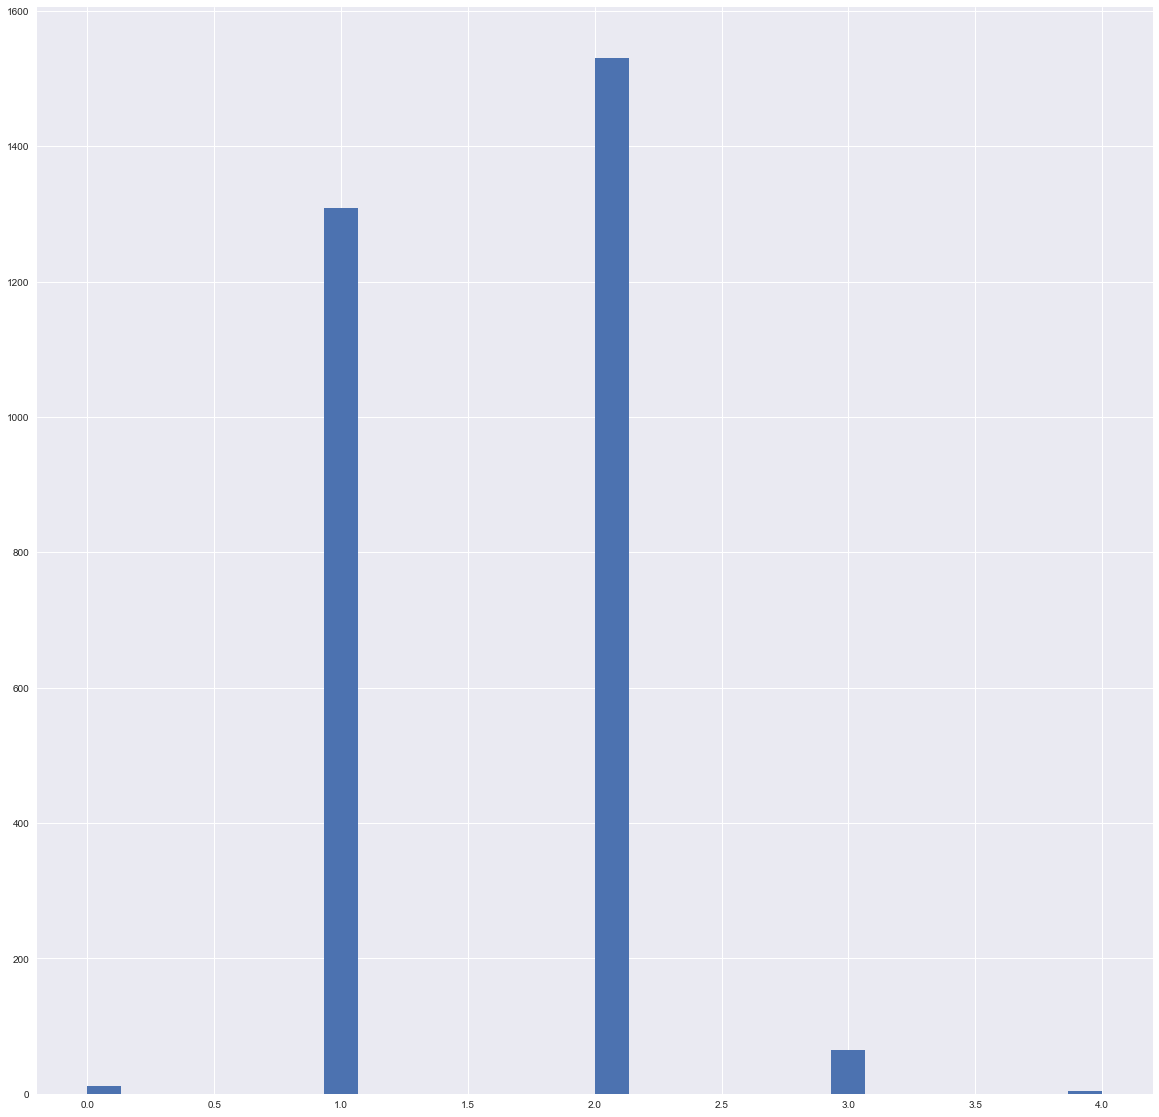

In [150]:
all_data["FullBath"].hist(bins=30,figsize=(20,20))
all_data.head(100)

### Transfer

In [151]:
transcol = ['LotArea','MasVnrArea','TotalBsmtSF','LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','LotFrontage','1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtUnfSF']


In [152]:
for i in transcol:
    all_data[i] = np.log1p(all_data[i])

In [153]:
all_data['GrLivArea'] = all_data['GrLivArea'] ** 0.5

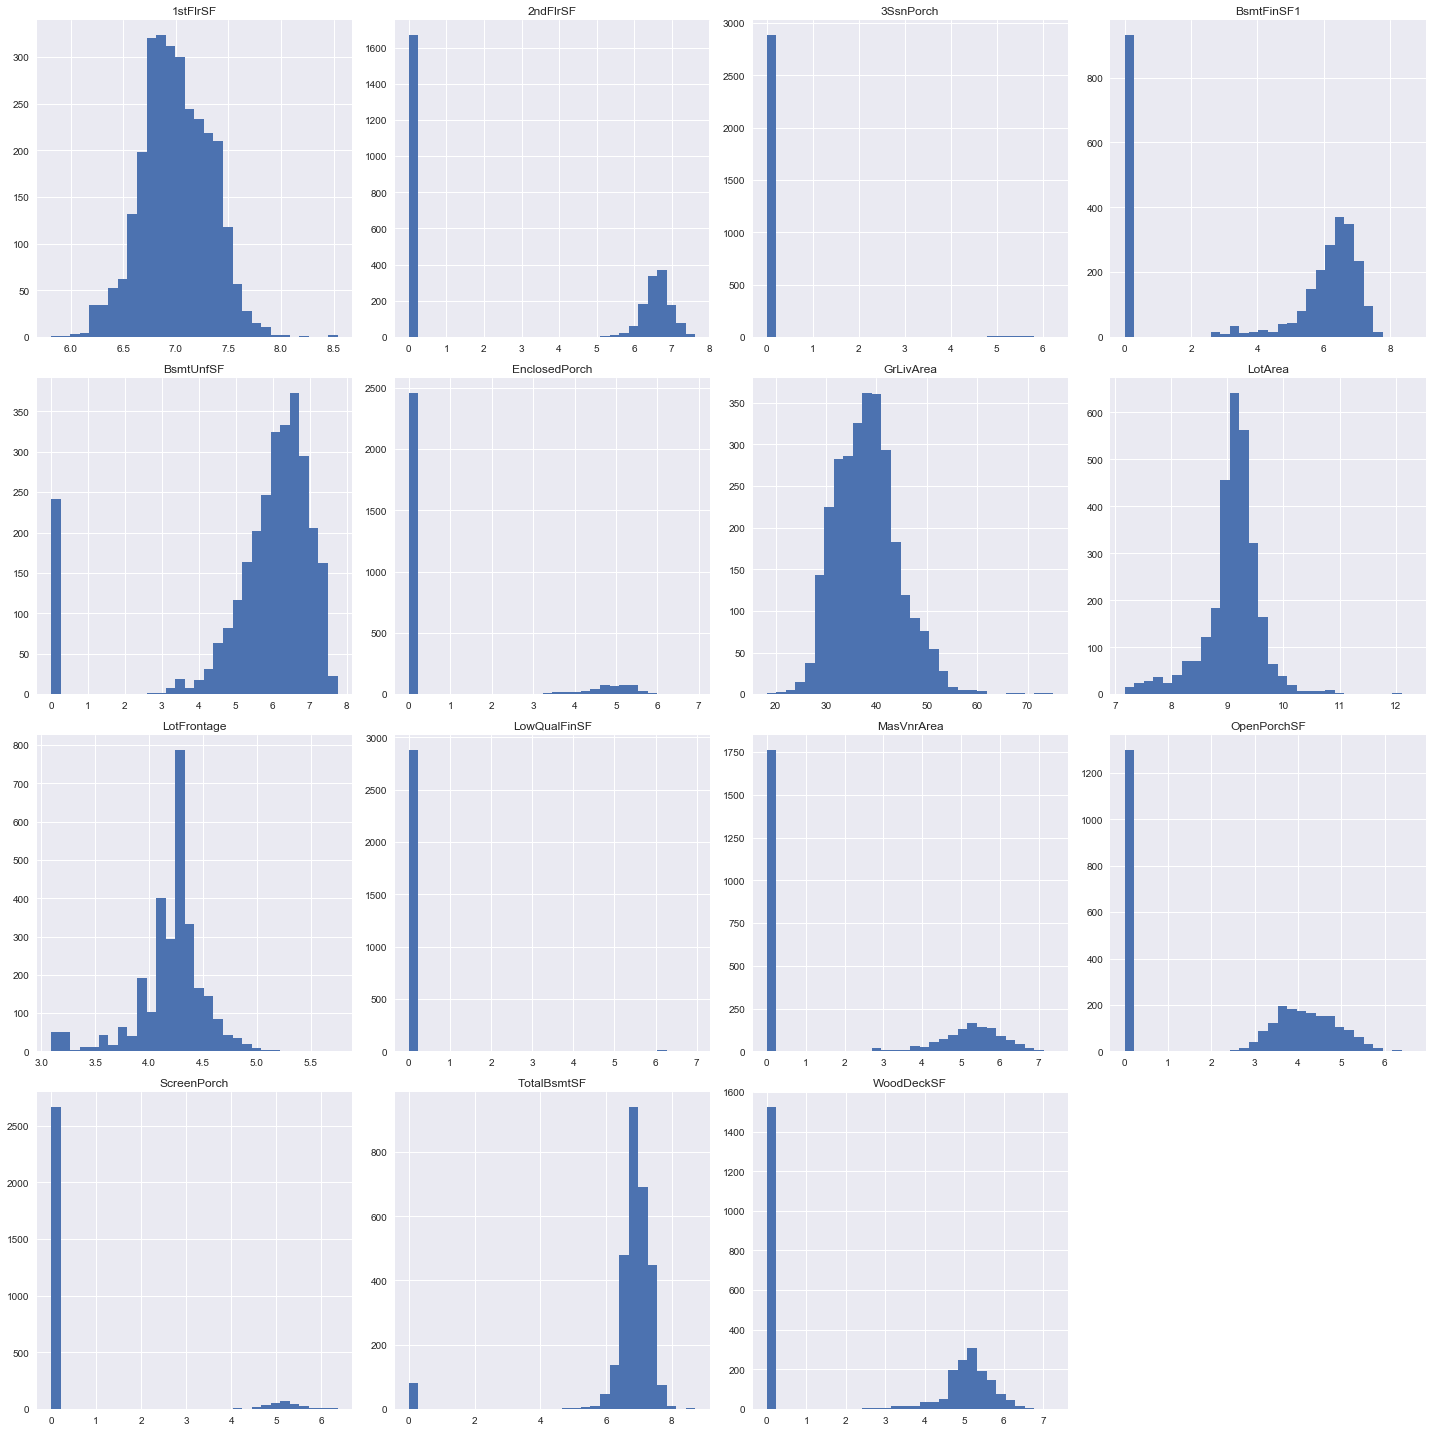

In [154]:
all_data.loc[:,transcol+["GrLivArea"]].hist(bins=30,figsize=(20,20))
plt.tight_layout()
plt.show()

In [155]:
all_data.head(100)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageCars,GarageFinish,GarageQual,GarageType,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearRemodAdd,YrSold,Remodornot,poolornot
0,6.753438,6.751101,0.000000,None,3,1Fam,TA,No,6.561031,0.0,GLQ,Unf,1.0,0.0,Gd,5.017280,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,None,None,0,PConc,2,Typ,2.0,RFn,TA,Attchd,41.352146,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,9.042040,Inside,4.189655,Reg,0.000000,60,RL,5.283204,BrkFace,None,0,CollgCr,4.127134,5,7,Y,CompShg,Gable,Normal,208500.0,WD,0.000000,Pave,8,6.753438,0.000000,2003,2008,1,0
1,7.141245,0.000000,0.000000,None,3,1Fam,TA,Gd,6.886532,0.0,ALQ,Unf,0.0,1.0,Gd,5.652489,Y,Feedr,Norm,SBrkr,0.000000,TA,TA,MetalSd,None,TA,1,CBlock,2,Typ,2.0,RFn,TA,Attchd,35.524639,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9.169623,FR2,4.394449,Reg,0.000000,20,RL,0.000000,None,None,0,Veenker,0.000000,8,6,Y,CompShg,Gable,Normal,181500.0,WD,0.000000,Pave,6,7.141245,5.700444,1976,2007,1,0
2,6.825460,6.765039,0.000000,None,3,1Fam,TA,Mn,6.188264,0.0,GLQ,Unf,1.0,0.0,Gd,6.075346,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,None,TA,1,PConc,2,Typ,2.0,RFn,TA,Attchd,42.261093,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,9.328212,Inside,4.234107,IR1,0.000000,60,RL,5.093750,BrkFace,None,0,CollgCr,3.761200,5,7,Y,CompShg,Gable,Normal,223500.0,WD,0.000000,Pave,6,6.825460,0.000000,2002,2008,0,0
3,6.869014,6.629363,0.000000,None,3,1Fam,Gd,No,5.379897,0.0,ALQ,Unf,1.0,0.0,TA,6.293419,Y,Norm,Norm,SBrkr,5.609472,TA,TA,Wd Sdng,None,Gd,1,BrkTil,1,Typ,3.0,Unf,TA,Detchd,41.436699,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9.164401,Corner,4.110874,IR1,0.000000,70,RL,0.000000,None,None,0,Crawfor,3.583519,5,7,Y,CompShg,Gable,Abnorml,140000.0,WD,0.000000,Pave,7,6.629363,0.000000,1970,2006,0,0
4,7.044033,6.960348,0.000000,None,4,1Fam,TA,Av,6.486161,0.0,GLQ,Unf,1.0,0.0,Gd,6.196444,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,None,TA,1,PConc,2,Typ,3.0,RFn,TA,Attchd,46.882833,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,9.565284,FR2,4.442651,IR1,0.000000,60,RL,5.860786,BrkFace,None,0,NoRidge,4.442651,5,8,Y,CompShg,Gable,Normal,250000.0,WD,0.000000,Pave,9,7.044033,5.262690,2000,2008,1,0
5,6.680855,6.340359,5.771441,None,1,1Fam,TA,No,6.597146,0.0,GLQ,Unf,1.0,0.0,Gd,4.174387,Y,Norm,Norm,SBrkr,0.000000,TA,TA,VinylSd,MnPrv,None,0,Wood,1,Typ,2.0,Unf,TA,Attchd,36.905284,1,GasA,Ex,1.5Fin,1,TA,Lvl,Gtl,9.555064,Inside,4.454347,IR1,0.000000,50,RL,0.000000,None,Shed,700,Mitchel,3.433987,5,5,Y,CompShg,Gable,Normal,143000.0,WD,0.000000,Pave,5,6.680855,3.713572,1995,2009,0,0
6,7.435438,0.000000,0.000000,None,3,1Fam,TA,Av,7.222566,0.0,GLQ,Unf,1.0,0.0,Ex,5.762051,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,None,Gd,1,PConc,2,Typ,2.0,RFn,TA,Attchd,41.158231,0,GasA,Ex,1Story,1,Gd,Lvl,Gtl,9.218804,Inside,4.330733,Reg,0.000000,20,RL,5.231109,Stone,None,0,Somerst,4.060443,5,8,Y,CompShg,Gable,Normal,307000.0,WD,0.000000,Pave,7,7.430707,5.545177,2005,2007,0,0
7,7.010312,6.891626,0.000000,None,3,1Fam,TA,Mn,6.756932,32.0,ALQ,BLQ,1.0,0.0,Gd,5.379897,Y,PosN,Norm,SBrkr,5.433722,TA,TA,HdBoard,None,TA,2,CBlock,2,Typ,2.0,RFn,TA,Attchd,45.716518,1,GasA,Ex,2Story,1,TA,Lvl,Gtl,9.247925,Corner,4.248495,IR1,0.000000,60,RL,5.484797,Stone,Shed,350,NWAmes,5.323010,6,7,Y,CompShg,Gable,Normal,200000.0,WD,0.000000,Pave,7,7.010312,5.463832,1973,2009,1,0
8,6.930495,6.624065,0.000000,None,2,1Fam,TA,No,0.000000,0.0,Unf,Unf,0.0,0.0,TA,6.859615,Y,Artery,Norm,FuseF,5.327876,TA,TA,BrkFace,None,TA,2,BrkTil,2,Min1,2.0,Unf,Fa,Detchd,

### Dummify

In [164]:
dummycol=['MSSubClass','HouseStyle','MSZoning','Street','Alley','LotShape','LandContour','LandSlope','LotConfig','Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2st','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','PavedDrive','Fence','MiscFeature','SaleType','SaleCondition']
for cols in all_data.columns:
    if all_data[cols].dtype == np.object and cols!= "Neighborhood":
        all_data = pd.concat((all_data, pd.get_dummies(all_data[cols], prefix=cols, drop_first=True)), axis=1)
        del all_data[cols]

In [165]:
all_data.head(100)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageCars,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,Neighborhood,OpenPorchSF,OverallQual,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearRemodAdd,Remodornot,poolornot,Alley_None,Alley_Pave,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,...,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,PavedDrive_P,PavedDrive_Y,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Pave,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,6.751101,0.000000,3,6.561031,0.0,1.0,0.0,5.017280,0.000000,0,2,2.0,41.352146,1,1,9.042040,4.189655,0.000000,5.283204,0,CollgCr,4.127134,7,208500.0,0.000000,8,6.753438,0.000000,2003,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
1,7.141245,0.000000,0.000000,3,6.886532,0.0,0.0,1.0,5.652489,0.000000,1,2,2.0,35.524639,0,1,9.169623,4.394449,0.000000,0.000000,0,Veenker,0.000000,6,181500.0,0.000000,6,7.141245,5.700444,1976,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0
2,6.825460,6.765039,0.000000,3,6.188264,0.0,1.0,0.0,6.075346,0.000000,1,2,2.0,42.261093,1,1,9.328212,4.234107,0.000000,5.093750,0,CollgCr,3.761200,7,223500.0,0.000000,6,6.825460,0.000000,2002,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
3,6.869014,6.629363,0.000000,3,5.379897,0.0,1.0,0.0,6.293419,5.609472,1,1,3.0,41.436699,0,1,9.164401,4.110874,0.000000,0.000000,0,Crawfor,3.583519,7,140000.0,0.000000,7,6.629363,0.000000,1970,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,7.044033,6.960348,0.000000,4,6.486161,0.0,1.0,0.0,6.196444,0.000000,1,2,3.0,46.882833,1,1,9.565284,4.442651,0.000000,5.860786,0,NoRidge,4.442651,8,250000.0,0.000000,9,7.044033,5.262690,2000,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
5,6.680855,6.340359,5.771441,1,6.597146,0.0,1.0,0.0,4.174387,0.000000,0,1,2.0,36.905284,1,1,9.555064,4.454347,0.000000,0.000000,700,Mitchel,3.433987,5,143000.0,0.000000,5,6.680855,3.713572,1995,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0
6,7.435438,0.000000,0.000000,3,7.222566,0.0,1.0,0.0,5.762051,0.000000,1,2,2.0,41.158231,0,1,9.218804,4.330733,0.000000,5.231109,0,Somerst,4.060443,8,307000.0,0.000000,7,7.430707,5.545177,2005,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0
7,7.010312,6.891626,0.000000,3,6.756932,32.0,1.0,0.0,5.379897,5.433722,2,2,2.0,45.716518,1,1,9.247925,4.248495,0.000000,5.484797,350,NWAmes,5.323010,7,200000.0,0.000000,7,7.010312,5.463832,1973,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1

In [169]:
train_df = all_data.iloc[0:1460,]
X_test = all_data.iloc[1460:,]
train_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageCars,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,Neighborhood,OpenPorchSF,OverallQual,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearRemodAdd,Remodornot,poolornot,Alley_None,Alley_Pave,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,...,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,PavedDrive_P,PavedDrive_Y,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Pave,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,6.751101,0.0,3,6.561031,0.0,1.0,0.0,5.017280,0.000000,0,2,2.0,41.352146,1,1,9.042040,4.189655,0.0,5.283204,0,CollgCr,4.127134,7,208500.0,0.0,8,6.753438,0.000000,2003,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
1,7.141245,0.000000,0.0,3,6.886532,0.0,0.0,1.0,5.652489,0.000000,1,2,2.0,35.524639,0,1,9.169623,4.394449,0.0,0.000000,0,Veenker,0.000000,6,181500.0,0.0,6,7.141245,5.700444,1976,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0
2,6.825460,6.765039,0.0,3,6.188264,0.0,1.0,0.0,6.075346,0.000000,1,2,2.0,42.261093,1,1,9.328212,4.234107,0.0,5.093750,0,CollgCr,3.761200,7,223500.0,0.0,6,6.825460,0.000000,2002,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
3,6.869014,6.629363,0.0,3,5.379897,0.0,1.0,0.0,6.293419,5.609472,1,1,3.0,41.436699,0,1,9.164401,4.110874,0.0,0.000000,0,Crawfor,3.583519,7,140000.0,0.0,7,6.629363,0.000000,1970,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,7.044033,6.960348,0.0,4,6.486161,0.0,1.0,0.0,6.196444,0.000000,1,2,3.0,46.882833,1,1,9.565284,4.442651,0.0,5.860786,0,NoRidge,4.442651,8,250000.0,0.0,9,7.044033,5.262690,2000,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0


### Outlier

In [167]:
train_df = train_df[train_df.GrLivArea < 4500]


In [168]:
train_df.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageCars,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,Neighborhood,OpenPorchSF,OverallQual,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearRemodAdd,Remodornot,poolornot,Alley_None,Alley_Pave,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,...,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,PavedDrive_P,PavedDrive_Y,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Pave,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,6.751101,0.0,3,6.561031,0.0,1.0,0.0,5.017280,0.000000,0,2,2.0,41.352146,1,1,9.042040,4.189655,0.0,5.283204,0,CollgCr,4.127134,7,208500.0,0.0,8,6.753438,0.000000,2003,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
1,7.141245,0.000000,0.0,3,6.886532,0.0,0.0,1.0,5.652489,0.000000,1,2,2.0,35.524639,0,1,9.169623,4.394449,0.0,0.000000,0,Veenker,0.000000,6,181500.0,0.0,6,7.141245,5.700444,1976,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0
2,6.825460,6.765039,0.0,3,6.188264,0.0,1.0,0.0,6.075346,0.000000,1,2,2.0,42.261093,1,1,9.328212,4.234107,0.0,5.093750,0,CollgCr,3.761200,7,223500.0,0.0,6,6.825460,0.000000,2002,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
3,6.869014,6.629363,0.0,3,5.379897,0.0,1.0,0.0,6.293419,5.609472,1,1,3.0,41.436699,0,1,9.164401,4.110874,0.0,0.000000,0,Crawfor,3.583519,7,140000.0,0.0,7,6.629363,0.000000,1970,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,7.044033,6.960348,0.0,4,6.486161,0.0,1.0,0.0,6.196444,0.000000,1,2,3.0,46.882833,1,1,9.565284,4.442651,0.0,5.860786,0,NoRidge,4.442651,8,250000.0,0.0,9,7.044033,5.262690,2000,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0


### Y

In [170]:
y_train.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [171]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


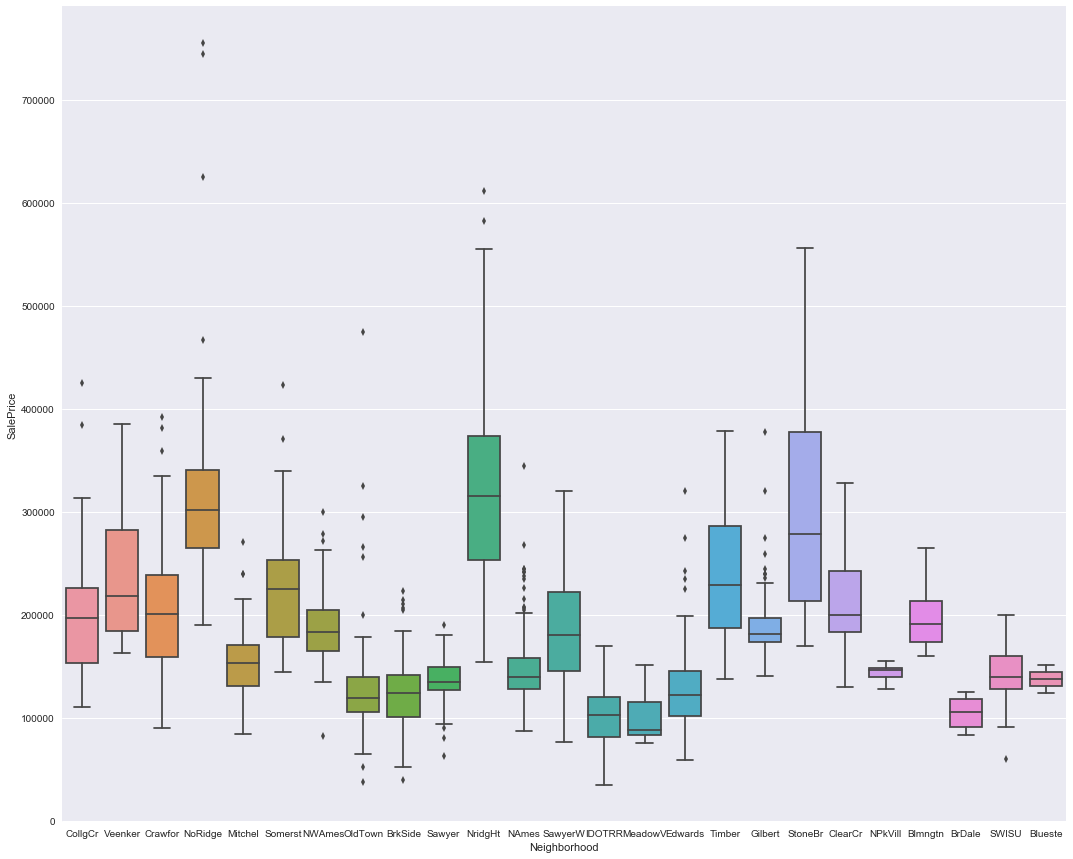

In [163]:
f, ax = plt.subplots(figsize=(18, 15))
ax = sns.boxplot(x=X_train["Neighborhood"], y=X_train["SalePrice"], data=X_train)

In [134]:
X_test.groupby("Neighborhood")["Neighborhood"].count()

Neighborhood
Blmngtn     11
Blueste      8
BrDale      14
BrkSide     50
ClearCr     16
CollgCr    117
Crawfor     52
Edwards     94
Gilbert     86
IDOTRR      56
MeadowV     20
Mitchel     65
NAmes      218
NPkVill     14
NWAmes      58
NoRidge     30
NridgHt     89
OldTown    126
SWISU       23
Sawyer      77
SawyerW     66
Somerst     96
StoneBr     26
Timber      34
Veenker     13
Name: Neighborhood, dtype: int64

In [136]:
high = ['Crawfor','NoRidge','NridgHt','StoneBr']
midhigh = ['Veenker','BrkSide','Timber','ClearCr','BrDale']
mid = ['CollgCr','SawyerW']
mid1 = ['Mitchel','Gilbert']
mid2 = ['SWISU','BrDale','NPkVill','Blueste','Sawyer','NAmes','SawyerW',"MeadowV"]
low = ["OldTown",'IDOTRR']

In [172]:
y_train = pd.DataFrame(np.log(train_df['SalePrice'] - train_df["MiscVal"]))
X_train = train_df.drop('SalePrice', axis=1)
X_test = X_test.drop('SalePrice', axis=1)

In [173]:

X_train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageCars,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,Neighborhood,OpenPorchSF,OverallQual,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearRemodAdd,Remodornot,poolornot,Alley_None,Alley_Pave,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,...,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,PavedDrive_P,PavedDrive_Y,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Pave,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,6.751101,0.0,3,6.561031,0.0,1.0,0.0,5.017280,0.000000,0,2,2.0,41.352146,1,1,9.042040,4.189655,0.0,5.283204,0,CollgCr,4.127134,7,0.0,8,6.753438,0.000000,2003,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
1,7.141245,0.000000,0.0,3,6.886532,0.0,0.0,1.0,5.652489,0.000000,1,2,2.0,35.524639,0,1,9.169623,4.394449,0.0,0.000000,0,Veenker,0.000000,6,0.0,6,7.141245,5.700444,1976,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0
2,6.825460,6.765039,0.0,3,6.188264,0.0,1.0,0.0,6.075346,0.000000,1,2,2.0,42.261093,1,1,9.328212,4.234107,0.0,5.093750,0,CollgCr,3.761200,7,0.0,6,6.825460,0.000000,2002,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
3,6.869014,6.629363,0.0,3,5.379897,0.0,1.0,0.0,6.293419,5.609472,1,1,3.0,41.436699,0,1,9.164401,4.110874,0.0,0.000000,0,Crawfor,3.583519,7,0.0,7,6.629363,0.000000,1970,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,7.044033,6.960348,0.0,4,6.486161,0.0,1.0,0.0,6.196444,0.000000,1,2,3.0,46.882833,1,1,9.565284,4.442651,0.0,5.860786,0,NoRidge,4.442651,8,0.0,9,7.044033,5.262690,2000,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0


### MiscV

In [174]:
train_MiscVal = pd.DataFrame(X_train["MiscVal"])
test_MiscVal = pd.DataFrame(X_test["MiscVal"])

In [175]:
X_test.to_csv("X_test1st.csv")
X_train.to_csv("X_train1st.csv")
y_train.to_csv("y_train1st.csv")
#train_MiscVal.to_csv("train_MiscVal.csv")
test_MiscVal.to_csv("test_MiscVal.csv")

# (2919 - all_data.count()).sort_values(ascending=False)
all_data['BldgType'].count()

import numpy as np

all_data['LotFrontageMissing'] = pd.isnull(all_data['LotFrontage'])

all_data['MSZoning_BldgType'] = all_data['MSZoning'] + all_data['BldgType']

all_data.pivot_table(index=['MSZoning','BldgType'],columns=['LotFrontageMissing'], values='1stFlrSF', aggfunc=len)

np.max(all_data['GrLivArea'] - all_data['1stFlrSF'] - all_data['2ndFlrSF'])

all_data['GrLivArea'].count()

(2919 - all_data.count()).sort_values(ascending =False)

all_data.drop('MSZoning_BldgType', axis=1, inplace=True)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

f, ax = plt.subplots(figsize=(18,15))
ax = sns.boxplot(x=all_data['MSZoning_BldgType'], y=all_data['LotFrontage'], data=all_data)

In [ ]:
from preprocess import impute
all_data = impute(all_data)

In [ ]:
all_data_2 = all_data.copy()
# plt.show()

In [ ]:
all_data_2['Pool']

In [ ]:
from sklearn.preprocessing import Binarizer
bnr = Binarizer()

In [ ]:
all_data_2['PoolFlag'] = bnr.fit_transform(all_data_2['PoolArea'].values.reshape(-1, 1))
all_data_2.drop(['PoolQC','PoolArea'], axis = 1, inplace = True)

In [ ]:
all_data_2['TotPorchSF'] = all_data_2['3SsnPorch'] + all_data_2['OpenPorchSF'] + \
                           all_data_2['ScreenPorch'] + all_data_2['EnclosedPorch'] # WoodDeckSF
all_data_2['TotPorchSF'] = np.log1p(all_data_2['TotPorchSF'])
all_data_2.drop(['3SsnPorch','OpenPorchSF','ScreenPorch','EnclosedPorch'], axis = 1, inplace = True)
all_data_2['PorchFlag'] = bnr.fit_transform(all_data_2['TotPorchSF'].values.reshape(-1, 1))

In [ ]:
all_data_2['WoodDeckFlag'] = bnr.fit_transform(all_data_2['WoodDeckSF'].values.reshape(-1, 1))
all_data_2['WoodDeckSF'] = np.log1p(all_data_2['WoodDeckSF'])

In [ ]:
# 
all_data_2['BsmtFlag'] = bnr.fit_transform(all_data_2['TotalBsmtSF'].values.reshape(-1, 1))


all_data_2['BsmtFinPerc'] = (all_data_2['BsmtFinSF1'] + all_data_2['BsmtFinSF2'])/all_data_2['TotalBsmtSF']


all_data_2['TotalBsmtSF'] = boxcox(1 + all_data_2['TotalBsmtSF'])[0]


all_data_2.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'], axis = 1, inplace = True)

# plt.show()# - all_data_2['BsmtFinSF1'] - all_data_2['BsmtFinSF2'] - all_data_2['BsmtUnfSF'])

In [ ]:
((all_data_2['BsmtFinSF1']+all_data_2['BsmtFinSF2'])/all_data_2['TotalBsmtSF']).hist()
plt.show()

In [ ]:
all_data_2

In [ ]:
boxcox(1+all_data_2['WoodDeckSF'])

In [ ]:
all_data_2.hist(bins = 30, figsize = (20,15))
plt.tight_layout()
plt.show()

## Feature Engineering - most creative aspect of Data Science

In [ ]:
# from sklearn.preprocessing import LabelEncoder

label_df = all_data.copy()

# le = LabelEncoder()

In [ ]:
dict1 = dict(zip(['NA','Po','Fa','TA','Gd','Ex'], range(6)))
dict2 = dict(zip(['None','No','Mn','Av','Gd'], range(5)))
dict3 = dict(zip(['None','Unf','LwQ','Rec','BLQ','ALQ','GLQ'], range(7)))
dict4 = dict(zip(['N','Y'], range(2)))
dict5 = dict(zip(['Mix','FuseP', 'FuseF', 'FuseA','SBrkr'], range(5)))
dict6 = dict(zip(['Sal','Sev', 'Maj2','Maj1','Mod','Min2','Min1','Typ'], range(8)))
dict7 = dict(zip(['None','Po','Fa','TA','Gd','Ex'], range(6)))
dict8 = dict(zip(['None','Unf','RFn','Fin'], range(4)))
dict9 = dict(zip(['N','P','Y'], range(3)))
dict10 = dict(zip(['None','MnWw','GdWo','MnPrv','GdPrv'], [0,1,2,1,2]))

In [ ]:
import numpy as np

In [ ]:
label_df['ExterQual'] = label_df['ExterQual'].map(lambda x:dict1[x]).astype(np.number)
label_df['ExterCond'] = label_df['ExterCond'].map(lambda x:dict1[x]).astype(np.number)
label_df['BsmtQual'] = label_df['BsmtQual'].map(lambda x:dict7[x]).astype(np.number)
label_df['BsmtCond'] = label_df['BsmtCond'].map(lambda x:dict7[x]).astype(np.number)
label_df['BsmtExposure'] = label_df['BsmtExposure'].map(lambda x:dict2[x]).astype(np.number)
label_df['BsmtFinType1'] = label_df['BsmtFinType1'].map(lambda x:dict3[x]).astype(np.number)
label_df['BsmtFinType2'] = label_df['BsmtFinType2'].map(lambda x:dict3[x]).astype(np.number)
label_df['HeatingQC'] = label_df['HeatingQC'].map(lambda x:dict1[x]).astype(np.number)
label_df['CentralAir'] = label_df['CentralAir'].map(lambda x:dict4[x]).astype(np.number)
label_df['Electrical'] = label_df['Electrical'].map(lambda x:dict5[x]).astype(np.number)
label_df['KitchenQual'] = label_df['KitchenQual'].map(lambda x:dict1[x]).astype(np.number)
label_df['Functional'] = label_df['Functional'].map(lambda x:dict6[x]).astype(np.number)
label_df['FireplaceQu'] = label_df['FireplaceQu'].map(lambda x:dict7[x]).astype(np.number)
label_df['GarageFinish'] = label_df['GarageFinish'].map(lambda x:dict8[x]).astype(np.number)
label_df['GarageQual'] = label_df['GarageQual'].map(lambda x:dict7[x]).astype(np.number)
label_df['GarageCond'] = label_df['GarageCond'].map(lambda x:dict7[x]).astype(np.number)
label_df['PavedDrive'] = label_df['PavedDrive'].map(lambda x:dict9[x]).astype(np.number)
label_df['PoolQC'] = label_df['PoolQC'].map(lambda x:dict7[x]).astype(np.number)
label_df['Fence'] = label_df['Fence'].map(lambda x:dict10[x]).astype(np.number)

In [ ]:
one_hot_df = pd.get_dummies(label_df, drop_first=True, dummy_na=True)
one_hot_df.head()

In [ ]:
X_train, X_test = one_hot_df.iloc[:1460,:], one_hot_df.iloc[1460:,]

In [ ]:
y_train_log = np.log(y_train) 

## Ridge Regression with Cross Validation

In [ ]:
# train-test split
from sklearn.model_selection import train_test_split
X_train_reduced, X_val, y_train_log_reduced, y_val = train_test_split(X_train, y_train_log, test_size=0.2, random_state=0)

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

alphas = np.logspace(-1, 0.1, 30)

plt.figure(figsize=(5, 3))

scores = [cross_val_score(linear_model.Ridge(alpha, normalize=True), X_train, y_train, 
                          cv=5, scoring='neg_mean_squared_log_error').mean() for alpha in alphas]
plt.plot(alphas, scores)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

# df_test = pd.DataFrame({'a':[1,2,3],'b':[1,2,3],'c':[3,2,1]})
# param_range
train_scores_mean

In [ ]:
# plot validation curves
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np

# from sklearn.datasets import load_digits
# from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

# digits = load_digits()
X, y = X_train_reduced, y_train_log_reduced

param_range = np.logspace(-1, 1, 30)
train_scores, test_scores = validation_curve(
    linear_model.Ridge(normalize=True), X, y, param_name="alpha", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plt.title("Validation Curve with Ridge Regression")
# plt.xlabel("$\alpha$")
# plt.ylabel("Score")
plt.figure(figsize=(10, 6))
plt.semilogx(param_range,pd.DataFrame({'train' : train_scores_mean, 'test' : test_scores_mean}))
plt.show()


# plt.ylim(0.0, 1.1)
# lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scoresaa_std, alpha=0.2,
#                  color="navy", lw=lw)
# plt.legend(loc="best")
plt.show()

In [ ]:
param_range[np.argmax(test_scores_mean)]

In [ ]:
test_scores_mean

In [ ]:
rr_best = linear_model.Ridge(alpha = 0.2212216291070449, normalize=True, random_state = 0)
rr_best.fit(X_train_reduced, y_train_log_reduced)
np.mean((rr_best.predict(X_val) - y_val)**2)

In [ ]:
rr_best_pred = np.exp(rr_best.predict(X_test))
rr_best_pred_csv = pd.DataFrame({'Id': test_ID, 'SalePrice': rr_best_pred})
rr_best_pred_csv.to_csv('rr1_yq.csv', index=False)

In [ ]:
from scipy.stats import boxcox

In [ ]:
boxcox(y_train)

### Categorical  features
- Nearly always need some treatment
- High cardinality can create very sparse data

#### One-hot encoding
- One-of-K encoding on an array of length K
- Basic method: used with most linear algorithm
- Drop first column avoids collinearity
 - encoding gender as two variables, **is_male** and **is_female**, produces two features which are perfectly negatively correlated
- Encode categories appearing 3+ times
 - Reduce training feature space with no loss of info.
- Will fail on new category. (See this [get_smarties](https://github.com/joeddav/get_smarties) package on Github for a quick fix)

In [ ]:
for c in all_data.columns:
    if all_data[c].dtype == 'object':
        print(c, len(all_data[c].value_counts()))

In [ ]:
one_hot_df = pd.get_dummies(all_data, drop_first=True, dummy_na=True)
one_hot_df.head()

#### Label encoding
- Give every categorial variable a unique numerical ID
- Useful for non-linear tree-based algorithm
- Does not increase dimensionality
- Will fail on new category

### Categorical Features with many categories - rows:category ratio 20:1 or less

#### Label Count encoding
- Rank categorical variables by count in the **training** set and transform the test set
- Iterate counter for each CV fold - fit on the **new training set** and transform on the **new test set**
- Useful for both linear or non-linear algorithms

In [ ]:
class LabelCountEncoder(object):
    def __init__(self):
        self.count_dict = {}
    
    def fit(self, column):
        # This gives you a dictionary with level as the key and counts as the value
        count = column.value_counts().to_dict()
        # We want to rank the key by its value and use the rank as the new value
        self.count_dict = {key[0]: rank+1 for rank, key in enumerate(sorted(count.items(), key=lambda x: x[1]))}
    
    def transform(self, column):
        # If a category only appears in the test set, we will assign the value to zero.
        missing = 0
        return column.apply(lambda x : self.count_dict.get(x, missing))
    
    def fit_transform(self, column):
        self.fit(column)
        return self.transform(column)

In [ ]:
label_count_df = X_train.copy()

for c in label_count_df.columns:
    if label_count_df[c].dtype == 'object':
        lce = LabelCountEncoder()
        label_count_df[c] = lce.fit_transform(label_count_df[c])

In [ ]:
label_count_df.head()

#### Interactions
- If interactions are natural for a problem - ML only does approximations! => sub-optimal
 - Start from interactions that make sense intuitively. 
 - Winners usually find something that most people struggle to see in data. **Not many people look at the data at all!**
 
|  GarageCond |   GarageType   | GarageCond * GarageType  |
| ------------|:--------------:| -----:|
|  Ex  | 2Types | Ex * 2Types |
|  Ex  | CarPort| Ex * CarPort|
|  TA  | Basement| TA * Basement|
|  Fa  | BuiltIn | Fa * BuiltIn |
 
 
- Test your method with all explicitly created possible 2-way interactions if you have enough computing power
- This is especially useful when dealing with **anonymous data** (column name unknown)
- If 2-way interactions help – go even further (3-way, 4-way, ...)

**Dealing with NA's depends on situation. NA itself is an information unit! Usually separate category is enough.**

### Numerical features
Feature transformations to consider:
- Scaling - min/max, N(0,1), root/power scaling, log scaling, Box-Cox, quantiles.
 - **[Fit on the training set and transform on the test set.](https://stats.stackexchange.com/a/174865)**
- Rounding (too much precision might be noise!)
- Interactions {+,-,*,/}
 - Since area related features are very important to determine house prices, we can add one more feature which is the total area of basement, first and second floor areas of each house
 - `all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']`
- Sometimes numerical features are categorical or even ordinal by nature.
 - `MSSubClass`, `OverallCond`, `OverallQual`, `YrSold`, `MoSold`
- **Tree methods are almost invariant to scaling**

**Everything you need to know about feature engineering is [here](https://www.slideshare.net/HJvanVeen/feature-engineering-72376750?qid=14629b24-6d05-4275-acc9-ea0743605071&v=&b=&from_search=1).**

## Parameter Tuning

#### Basic approach: apply grid search on all parameter space
- Zero effort and no supervision
- Enormous parameter space
- Very time consuming

#### Expert approach: experience + intuition + resources at hand
1. Pick one set of parameters from the Kaggle kernel or the golden parameter you used in the previous competition
2. Start with the parameter that doesn't affect the others too much
 - i.e. learning rate $\eta $ in boosting method doesn't influence other parameter tuning (from my experience)
 - `max_depth`, `min_samples_split` and `min_samples_leaf` in random forest are highly correlated with each other
3. Iteratively tuning the features that control overfitting/underfitting
 - If it helps on CV, try to tune it as much as possible. Stop after CV score converges.
 - You can use public leaderboard as your K+1 fold to further prove it.
4. Go back to step 2 and stop when you are satisfied with the result and won't regret not working harder.  


#### [Bayesian optimization method](https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb): trade-off between expert and grid search approach
- Zero effort and no supervision
- Grid space reduced on previous iteration's results (mimic expert decisions)
- Time consuming (still)
- Easy to integrate with sklearn cross validation function. See [examples](https://github.com/fmfn/BayesianOptimization/blob/master/examples/sklearn_example.py) here.

#### Golden rule: finding optimal configuration rarely is a good time investment!

## Ensemble

#### [Ensembling by voting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
```
1111111100 = 80% accuracy 
0111011101 = 70% accuracy 
1000101111 = 60% accuracy
```
**Majority Vote**
```
1111111101 = 90% accuracy
```

In [ ]:
from sklearn.ensemble import VotingClassifier

#### Ensembling by averaging
- Let’s say we have N predictions from N different models: $y_1, y_2, ... , y_N$
- We want to make a single prediction using weighted average: $\beta_1*y_1+\beta_2*y_2+...+\beta_N*y_N$
- How do we find the best beta cofficients?
- Very common mistake to select weights based on leaderboard feedback
 - **inefficient & prone to leaderboard overfitting**
- Solve the problem using CV predictions with optimization algorithms 
 - $optim(\beta_1*y_1+\beta_2*y_2+...+\beta_N*y_N)$ with starting weights $\beta_i=1/N$

## Stacked Generalization

The procedure for a 5 fold stacking may be described as follows:

1. Split the total training set into two disjoint sets (here train and holdout)

2. Train several base models on the first part (train)

3. Predict these base models on the second part (holdout)

4. Repeat step 1-3 five times and use the holdout predictions as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.


- For the test set, we could either average the predictions of all base models on the test data or refit the model using the whole training set and then predict. Generally speaking, either way is fine because the test set hasn't seen the training set.
- If we ran 10 models using the same procedure, our meta model will have 10 input features.

![img](https://s3.amazonaws.com/nycdsabt01/stacking.jpg)

Borrowed from [Faron](https://www.kaggle.com/getting-started/18153#post103381)

As a quick note, one should try a few diverse models. To my experience, a good stacking solution is often composed of at least:
- 2 or 3 GBMs/XGBs/LightGBMs (one with low depth, one with medium and one with high)
- 1 or 2 Random Forests (again as diverse as possible–one low depth, one high)
- 1 linear model

In [ ]:
# Useful if you are debugging the function inside another .py script
%load_ext autoreload
%autoreload 2

In [ ]:
from sklearn.linear_model import ElasticNet, LinearRegression as lr
from sklearn.ensemble import GradientBoostingRegressor as gbr, RandomForestRegressor as rfr


In [ ]:
train_index = len(X_train)
for col in all_data.columns:
    if all_data[col].dtype == "object":
        lce = LabelCountEncoder()
        all_data[col][:train_index] = lce.fit_transform(all_data[col][:train_index])
        all_data[col][train_index:] = lce.transform(all_data[col][train_index:])

In [ ]:
X_train = all_data.iloc[:train_index, :]
X_test = all_data.iloc[train_index:, :]

In [ ]:
from stacking import stacking_regression
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

In [ ]:
models = [
    # linear model, ElasticNet = lasso + ridge
    ElasticNet(random_state=0),
    
    # conservative random forst model
    rfr(random_state=0,
        n_estimators=1000, max_depth=6,  max_features='sqrt'),
    
    # aggressive random forst model
    rfr(random_state=0, 
        n_estimators=1000, max_depth=9,  max_features='auto'),
    
    # conservative gbm model
    gbr(random_state=0, learning_rate = 0.005, max_features='sqrt',
        min_samples_leaf=15, min_samples_split=10, 
        n_estimators=3000, max_depth=3),
    
    # aggressive gbm model
    gbr(random_state = 0, learning_rate = 0.01, max_features='sqrt',
        min_samples_leaf=10, min_samples_split=5, 
        n_estimators = 1000, max_depth = 9)
    ]

meta_model = lr(normalize=True)

In [ ]:
%%time
stacking_prediction = stacking_regression(models, meta_model, X_train, y_train, X_test,
                               transform_target=np.log1p, transform_pred = np.expm1, 
                               metric=rmsle, verbose=1)

**Having more models than necessary in ensemble may hurt.**

Lets say we have a library of created models. Usually greedy-forward approach works well:
- Start with a few well-performing models’ ensemble
- Loop through each other model in a library and add to current ensemble
- Determine best performing ensemble configuration
- Repeat until metric converged

If you are using linear regression as the meta model, make sure you have **diverse/uncorrelated** first layer models

During each loop iteration it is wise to consider only a subset of library models, which could work as a regularization for model selection.

Repeating procedure few times and bagging results reduces the possibility of overfitting by doing model selection.

Another [great walkthrough](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) of stacking on Kaggle using the famous Titanic dataset.

R users can call the `stackedEnsemble()` function from the [H2o package](https://h2o-release.s3.amazonaws.com/h2o/rel-ueno/2/docs-website/h2o-docs/data-science/stacked-ensembles.html) directly.

### Success formula (personal opinion)

50% - feature engineering

30% - model diversity

10% - luck

10% - proper ensembling
 - Voting
 - Averaging
 - Stacking